# Designing Fibers

**Scott Prahl**

**Sept 2023**

In [1]:
# Jupyterlite support for ofiber
try:
    import micropip
    await micropip.install("ofiber")
except ModuleNotFoundError:
    pass

import numpy as np
import matplotlib.pyplot as plt
import scipy
import ofiber

# to make graphs a bit better
%config InlineBackend.figure_format='retina'

## Find the GeO₂ doping needed to minimize material dispersion at 1300nm

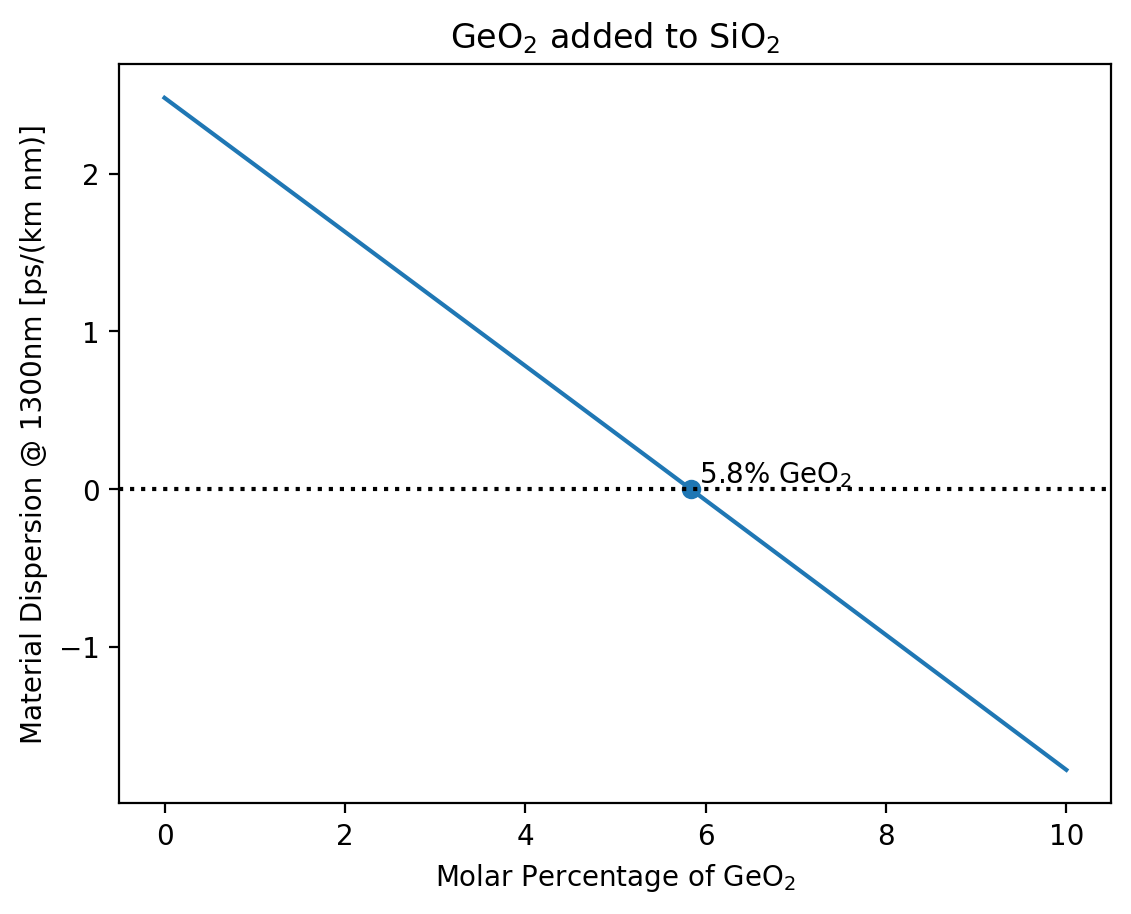

In [2]:
def smfconc(x):
    core_glass = ofiber.doped_glass(x)
    return ofiber.Material_Dispersion(core_glass,1300e-9)   # s/m**2

x = np.linspace(0,0.1,50)
M = np.empty_like(x)
for i in range(len(x)):
    core_glass = ofiber.doped_glass(x[i])
    M[i]  = ofiber.Material_Dispersion(core_glass,1300e-9)   # s/m**2
M *= 1e6                                             # ps/(km nm)
plt.plot(x*100,M)
plt.axhline(0,color='black',ls=':')

xx = scipy.optimize.brentq(smfconc,0,0.1)
plt.scatter([xx*100],[smfconc(xx)])
plt.annotate(' %.1f%% GeO$_2$'%(xx*100), xy=(xx*100,0),va='bottom')
plt.xlabel("Molar Percentage of GeO$_2$")
plt.ylabel("Material Dispersion @ 1300nm [ps/(km nm)]")
plt.title('GeO$_2$ added to SiO$_2$')
plt.show()

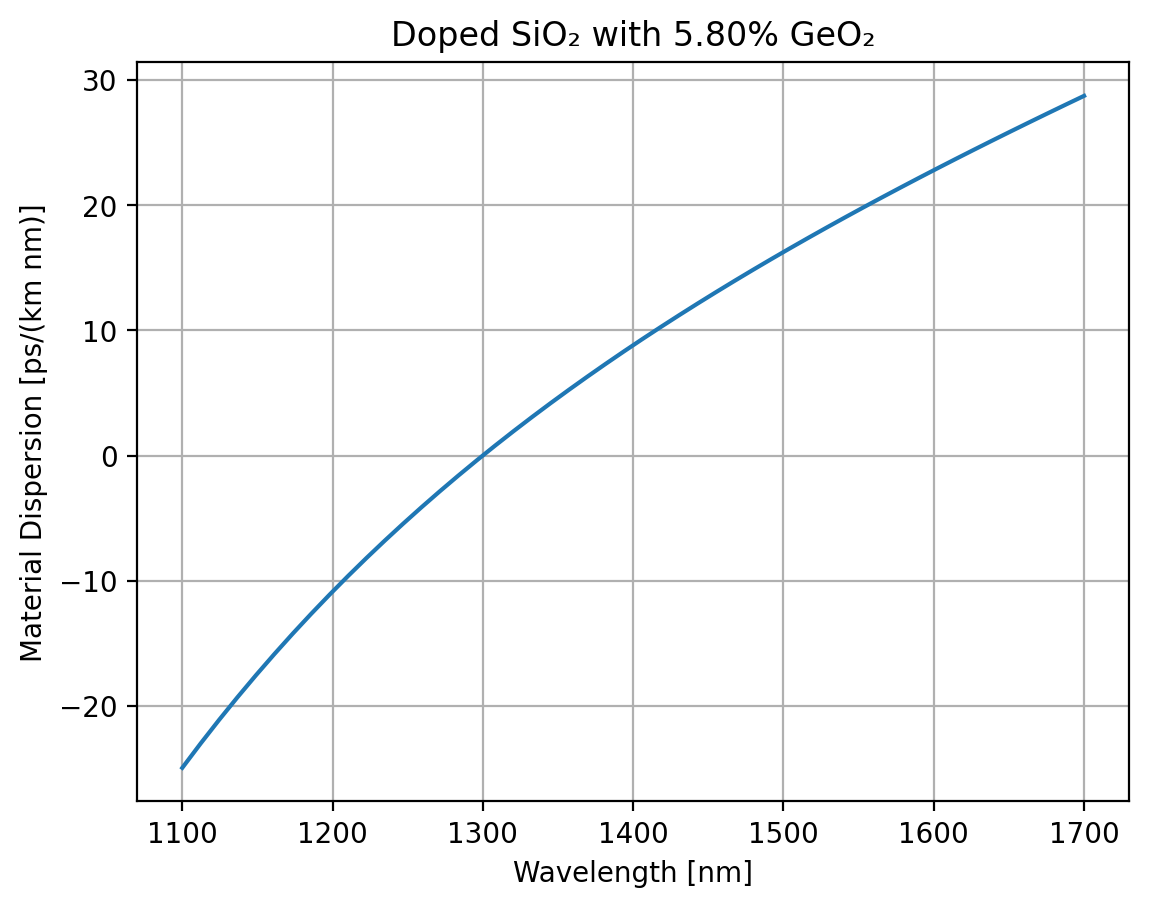

In [3]:
λ = np.linspace(1100,1700)*1e-9

GeO2_fraction = 0.058
core_glass = ofiber.doped_glass(GeO2_fraction)

dm  = ofiber.Material_Dispersion(core_glass,λ) * 1e6  # ps/(km nm)

plt.plot(λ*1e9, dm)

plt.xlabel("Wavelength [nm]")
plt.ylabel("Material Dispersion [ps/(km nm)]")
plt.title('Doped SiO₂ with %.2f%% GeO₂'%(100*GeO2_fraction))
plt.grid('on')
plt.show()

## Find the GeO₂ doping needed to minimize total dispersion at 1313nm

First, create a function that returns the total dispersion for an optical fiber with a cladding made out of pure SiO₂.  The core is doped with a molar fraction $x$ of GeO₂.  The core radius and the wavelength are passed as a final set of arguments.

In [4]:
def dt_mixture(x, *args):
    """
    Total dispersion for (x)GeO₂ : (1-x)SiO₂ glass fiber.
    
    The cladding is assumed to be pure SiO₂ surrounding a GeO₂ doped core
    with specified radius.
    
    The returned dispersion is in ps/km/nm
    """
    r_core = args[0]  # core radius [m]
    λ = args[1]  # core wavelength [m]

    cladding = ofiber.doped_glass(0)
    core = ofiber.doped_glass(x)

    n_clad = ofiber.n(cladding, λ)

    dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)
    return (dm+dw)*1e6

Plot the waveguide and material dispersion along with the total dispersion.  Use Brent's method to numerically find the doping of the core that gives no total dispersion at the designated wavelength.

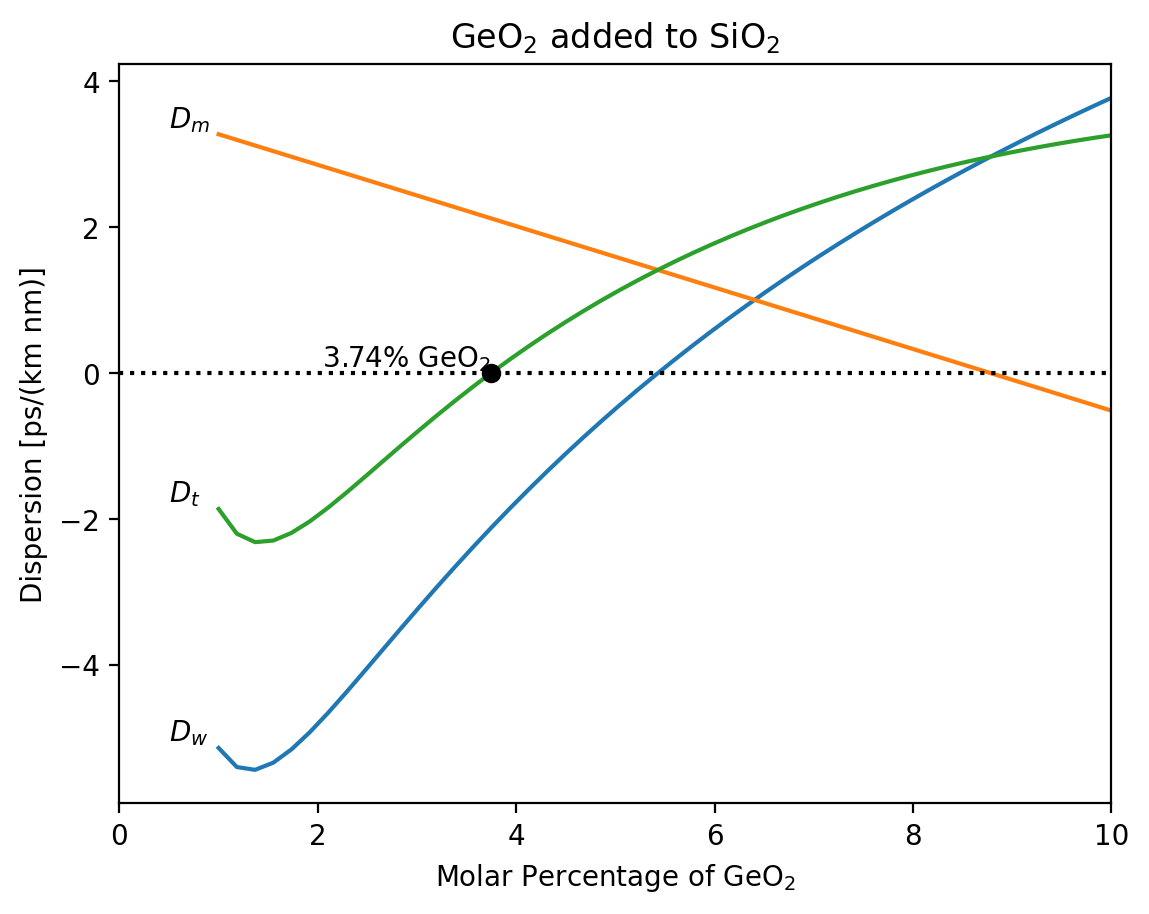

In [5]:
r_core = 4.1e-6 #m
design_λ = 1313e-9

cladding = ofiber.doped_glass(0)
n_clad = ofiber.n(cladding, design_λ)

x = np.linspace(0.01, 0.1)
Dm = np.empty_like(x)
Dw = np.empty_like(x)

for i,xx in enumerate(x):
    core_glass = ofiber.doped_glass(xx)
    n_core = ofiber.n(core_glass, design_λ)
    Dm[i] = ofiber.Material_Dispersion(core_glass, design_λ)              # s/m**2
    Dw[i] = ofiber.Waveguide_Dispersion(n_core, n_clad, r_core, design_λ) # s/m**2
    
Dm *= 1e6                                                        # ps/(km nm)
Dw *= 1e6                                                        # ps/(km nm)

# plot waveguide, material, and total dispersion
plt.plot(x*100, Dw)
plt.text(0.5, Dw[0], '$D_w$', va='bottom', ha='left')

plt.plot(x*100, Dm)
plt.text(0.5, Dm[0], '$D_m$', va='bottom', ha='left')

plt.plot(x*100, Dm+Dw)
plt.text(0.5, Dm[0]+Dw[0], '$D_t$', va='bottom', ha='left')

plt.axhline(0, color='black', ls=':')

# find and label the zero dispersion concentration
xx = scipy.optimize.brentq(dt_mixture, 0.02, 0.1, args=(r_core, design_λ))

Dtxx = dt_mixture(xx, r_core, design_λ)
plt.plot([xx*100],[Dtxx],'ok')
plt.text(xx*100, Dtxx, ' %.2f%% GeO$_2$'%(xx*100), va='bottom', ha='right')

plt.xlabel("Molar Percentage of GeO$_2$")
plt.ylabel("Dispersion [ps/(km nm)]")
plt.title('GeO$_2$ added to SiO$_2$')
plt.xlim(0,10)
plt.show()

Replot as a function of wavelength.

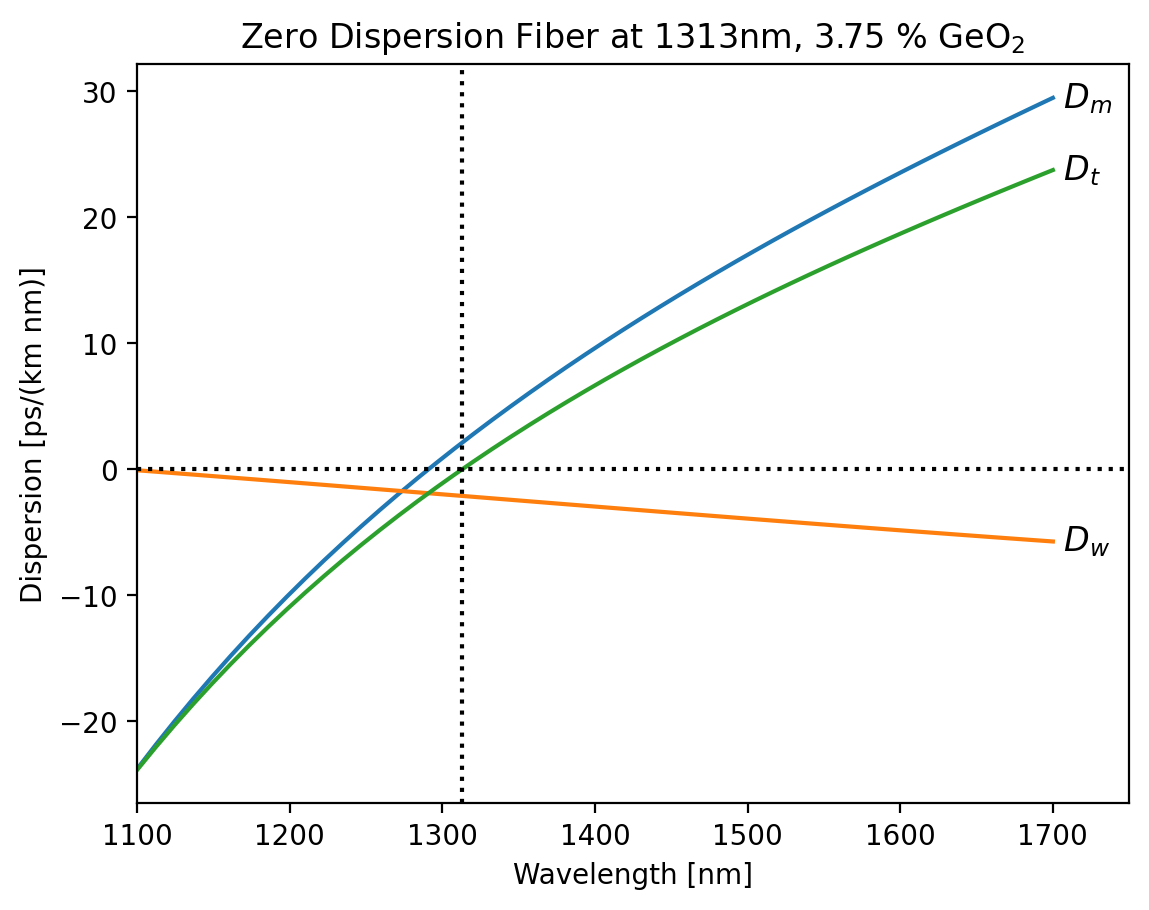

In [6]:
r_core = 4.1e-6    # meters
x = 0.0375
λ = np.linspace(1100,1700)*1e-9

cladding = ofiber.doped_glass(0)
n_clad = ofiber.n(cladding, λ)

core_glass = ofiber.doped_glass(x)
n_core = ofiber.n(core_glass, λ)

Dm = ofiber.Material_Dispersion(core_glass,λ)*1e6               # ps/(km nm)
Dw = ofiber.Waveguide_Dispersion(n_core, n_clad, r_core, λ)*1e6 # ps/(km nm)
Dt = Dm+Dw

plt.plot(λ*1e9,Dm)
plt.plot(λ*1e9,Dw)
plt.plot(λ*1e9,Dt)

plt.text(1700, Dw[-1], ' $D_w$', va='center', fontsize=12)
plt.text(1700, Dm[-1], ' $D_m$', va='center', fontsize=12)
plt.text(1700, Dw[-1]+Dm[-1], ' $D_t$',va='center', fontsize=12)

plt.axvline(1313, color='black', ls=':')
plt.axhline(0, color='black', ls=':')
plt.xlim(1100,1750)

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km nm)]")
plt.title('Zero Dispersion Fiber at 1313nm, %.2f %% GeO$_2$'%(x*100))
plt.show()

## Design of fiber at 1550nm for minimum total dispersion

What is the core diameter?

Assume that the cladding is pure SiO₂

V=2.112


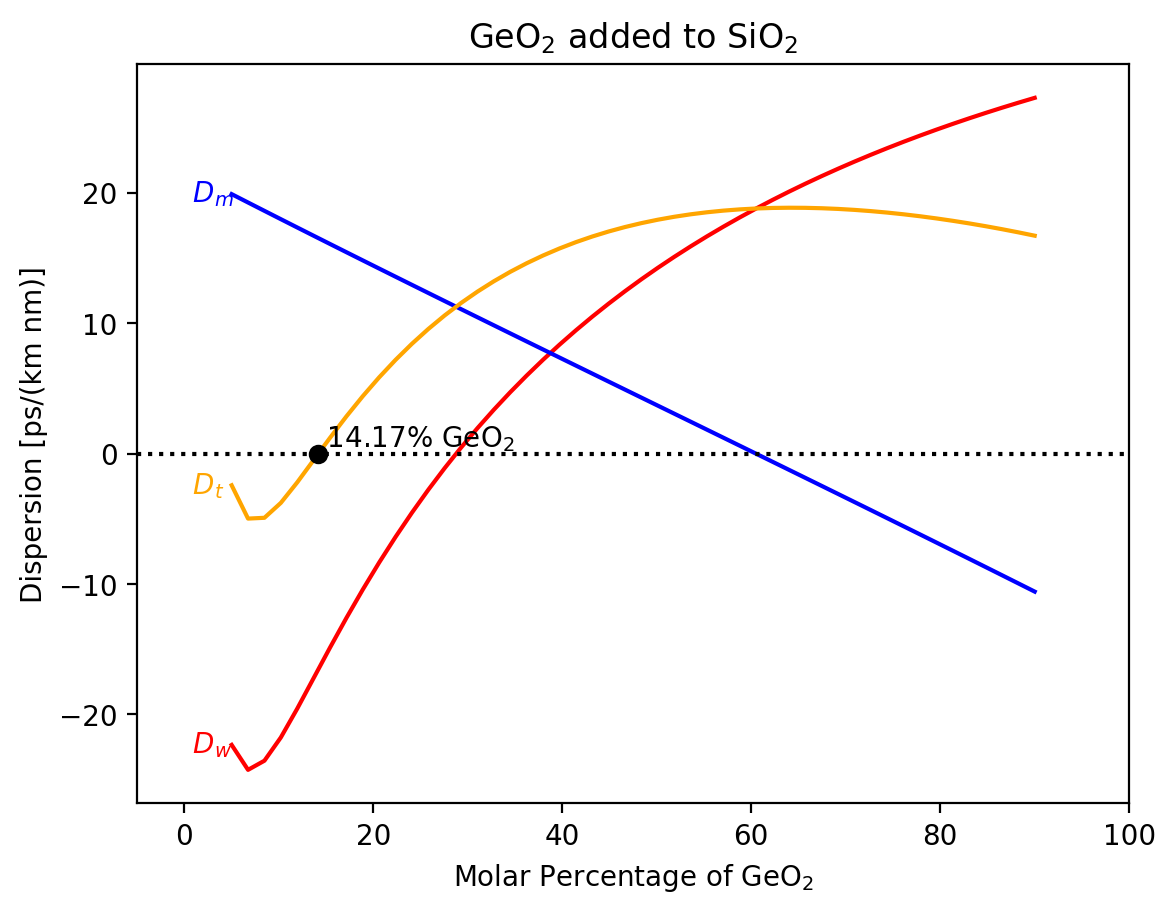

In [7]:
r_core = 2.1e-6      # meters
design_λ = 1550e-9 # meters

cladding = ofiber.doped_glass(0)
n_clad = ofiber.n(cladding, design_λ)

x = np.linspace(0.05, 0.9)
Dm = np.empty_like(x)
Dw = np.empty_like(x)

for i,xx in enumerate(x):
    core_glass = ofiber.doped_glass(xx)
    n_core = ofiber.n(core_glass, design_λ)
    Dm[i] = ofiber.Material_Dispersion(core_glass, design_λ)*1e6              # ps/(km nm)
    Dw[i] = ofiber.Waveguide_Dispersion(n_core, n_clad, r_core, design_λ)*1e6 # ps/(km nm)

# plot waveguide, material, and total dispersion
plt.plot(x*100, Dw, 'red')
plt.text(0, Dw[0], ' $D_w$', va='center', ha='left', color='red')

plt.plot(x*100, Dm, 'blue')
plt.text(0, Dm[0], ' $D_m$', va='center', ha='left', color='blue')

plt.plot(x*100, Dm+Dw, 'orange')
plt.text(0, Dm[0]+Dw[0], ' $D_t$', va='center', ha='left', color='orange')

plt.axhline(0, color='black', ls=':')

# find the zero dispersion concentration
xx = scipy.optimize.brentq(dt_mixture, 0.1, 0.9, args=(r_core, design_λ))

core = ofiber.doped_glass(xx)
n_core = ofiber.n(core, design_λ)
V = 2*np.pi*r_core/design_λ * np.sqrt(n_core**2-n_clad**2)
print("V=%.3f"%V)

# label the zero dispersion concentration
Dtxx = dt_mixture(xx, r_core, design_λ)
plt.plot([xx*100],[Dtxx],'ok')
plt.text(xx*100, Dtxx, ' %.2f%% GeO$_2$'%(xx*100), va='bottom')

plt.xlim(-5,100)
plt.xlabel("Molar Percentage of GeO$_2$")
plt.ylabel("Dispersion [ps/(km nm)]")
plt.title('GeO$_2$ added to SiO$_2$')
plt.show()

So we see that the fiber above is not single mode because V>2.4.  The only thing that we can change is the fiber radius.

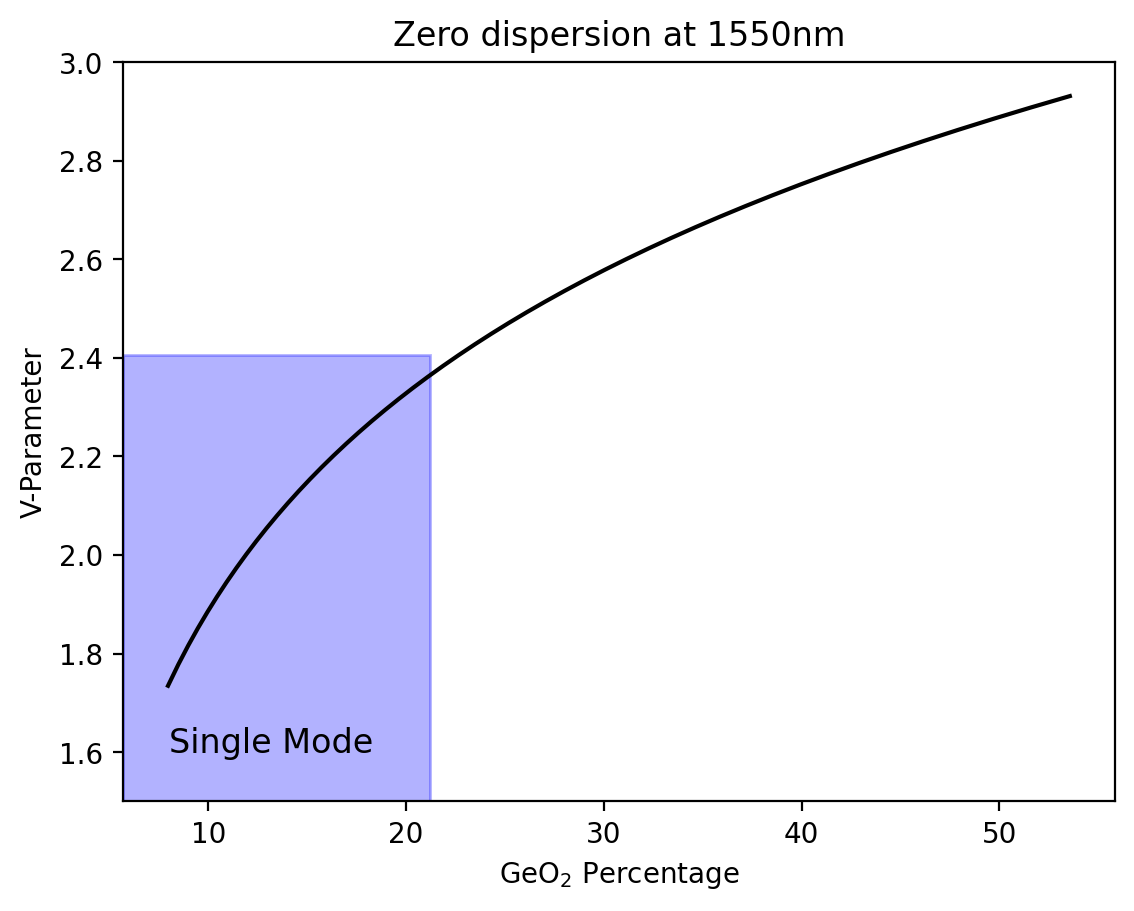

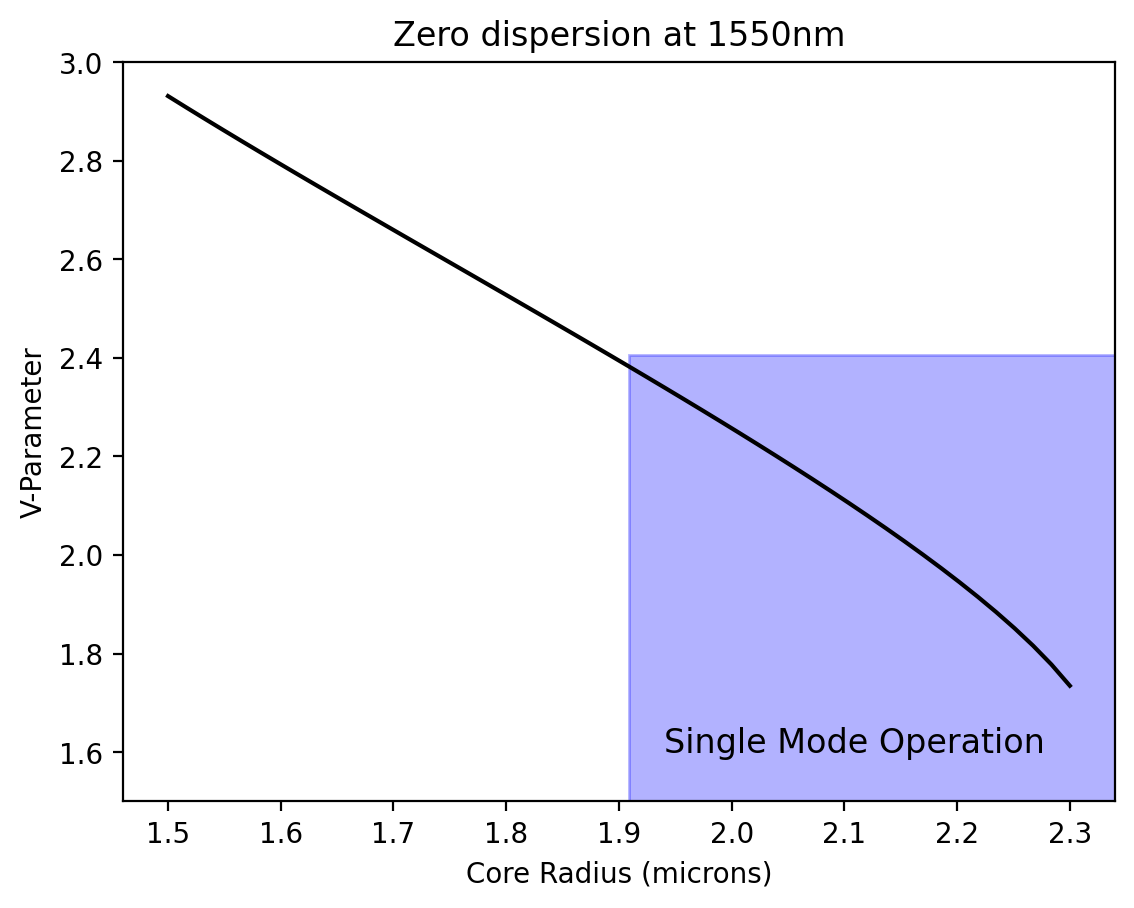

In [8]:
design_λ = 1550e-9 # meters

r_core = np.linspace(1.5,2.3)*1e-6  # meters
x = np.empty_like(r_core)
n_core = np.empty_like(r_core)

cladding = ofiber.doped_glass(0)
n_clad = ofiber.n(cladding, design_λ)

# find the zero dispersion concentration
for i, r in enumerate(r_core):
    x[i] = scipy.optimize.brentq(dt_mixture, 0.06, 0.6, args=(r, design_λ))
    core_glass = ofiber.doped_glass(x[i])
    n_core[i] = ofiber.n(core_glass, design_λ)

V = 2*np.pi*r_core/design_λ * np.sqrt(n_core**2-n_clad**2)

plt.plot(x*100,V,'k')
plt.axhspan(0, 2.405, xmax=0.31, color='blue', alpha=0.3)
plt.text(8, 1.6, 'Single Mode', fontsize=12)
plt.xlabel("GeO$_2$ Percentage")
plt.ylabel("V-Parameter")
plt.title('Zero dispersion at 1550nm')
plt.ylim(1.5,3)
plt.show()

plt.plot(r_core*1e6,V,'k')
plt.axhspan(0, 2.405, xmin=0.51, color='blue', alpha=0.3)
plt.text(1.94, 1.6, 'Single Mode Operation', fontsize=12)
plt.xlabel("Core Radius (microns)")
plt.ylabel("V-Parameter")
plt.title('Zero dispersion at 1550nm')
plt.ylim(1.5,3)
plt.show()